**Final Project: Breast Cancer**
=

***Advanced Methods of Artificial Vision***

**Authors:** *Alejandro Araque Robles, Ander Bodegas Díez, Lucía Gonzalez Ratón y Gonzalo Sabando Alonso*

**1. Introduction**
-

Breast cancer is one of the most common and life-threatening diseases affecting women worldwide, and its early and accurate diagnosis is crucial for improving patient outcomes. Medical imaging techniques such as mammography, ultrasound, and histopathology play a key role in supporting clinical decision-making. However, manual interpretation of these images is time-consuming and subject to inter-observer variability, which has motivated the development of automated computer-aided diagnosis (CAD) systems.

In recent years, machine learning (ML) and deep learning (DL) approaches have shown remarkable performance in medical image analysis, particularly for tasks such as tumor segmentation and classification. Many existing studies address breast cancer classification by directly learning from full images. While effective, this strategy may include irrelevant background information that can negatively affect model performance and interpretability. Focusing explicitly on tumor regions can help extract more meaningful features and better reflect the clinical reasoning process.

In this project, we explore a two-stage pipeline for breast cancer image classification using a publicly available Kaggle breast cancer image dataset. The first stage consists of segmenting tumor regions from the input images, isolating the areas most relevant for diagnosis. In the second stage, the segmented tumor information is used to classify images as benign or malignant. This classification task is approached from three different perspectives: (i) traditional machine learning methods using handcrafted features extracted from the segmented regions, (ii) deep learning models that learn discriminative features directly from the segmented images, and (iii) an hybrid approach that combines deep learning representations with classical ML classifiers.

By comparing these different strategies, this project aims to assess the impact of explicit tumor segmentation on breast cancer classification performance, as well as to analyze the strengths and limitations of ML, DL, and mixed approaches in this medical imaging context.

First of all, required packaged are installed and imported, and drive is mounted to get access to the dataset.

## Installs

In [1]:
!pip install segmentation_models_pytorch
!pip install openpyxl
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 40.6 MB/s eta 0:00:00


## Imports

In [2]:
from google.colab import drive
from PIL import Image

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchmetrics
import time
import random
import pandas as pd
import albumentations as A
import segmentation_models_pytorch as smp

## Mount Drive

In [3]:
drive.mount('/content/drive')

# Ruta Ander
pathRoot = '/content/drive/MyDrive/Colab Notebooks/Admeav/FinalProjectAdmeav'

Mounted at /content/drive


**2. Exploratory Data Analysis**
-

In this section, the original data will be explored and preprocessed to obtain a consistent dataset for the segmentation and classification tasks.

## 2.1. Visual Data Exploration

Data is structured in two folders: benign and malignant. In each folder, ultrasound images are stored along with their masks, which can be more than one for each image. In this section we will explore these data.

- breast_ultrasound
  - benign
  - malignant

In [4]:
# Benign and malignant file paths
pathB = os.path.join(pathRoot, 'breast_ultrasound', 'benign')
pathM = os.path.join(pathRoot, 'breast_ultrasound', 'malignant')

# Benign and malignant file lists
listB = os.listdir(pathB)
listM = os.listdir(pathM)

# Benign and malignant image lists
listImgB = [x for x in listB if 'mask' not in x]
listImgM = [x for x in listM if 'mask' not in x]

# Benign and malignant masks lists
listMasB = [x for x in listB if 'mask' in x]
listMasM = [x for x in listM if 'mask' in x]

First of all, we're going to visualize some of the images and masks of the dataset.

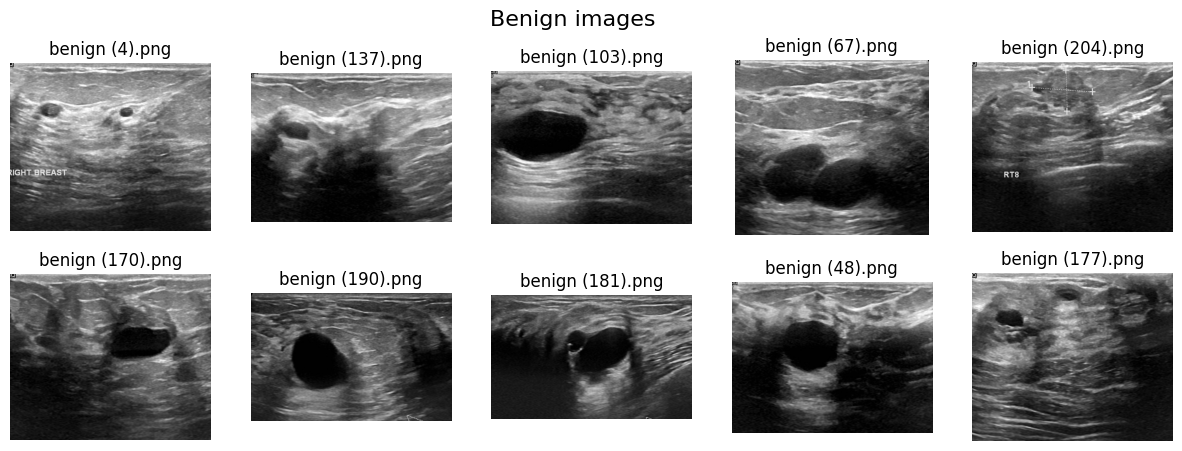

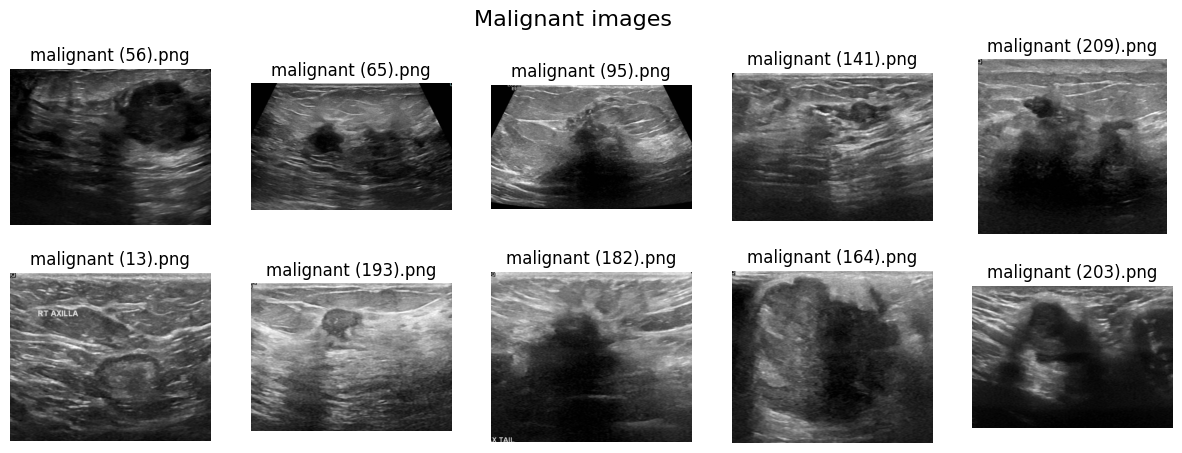

In [8]:
# Set seed for reproducibility
random.seed(42)

# Benign images
fig, ax = plt.subplots(2, 5, figsize = (15, 5))
ax = ax.flatten()
plt.suptitle('Benign images', fontsize = 16)

for i in range(10):
  name = random.choice(listImgB)
  img = cv2.imread(os.path.join(pathB, name), flags = cv2.IMREAD_UNCHANGED)
  ax[i].imshow(img)
  ax[i].axis('off')
  ax[i].set_title(name)

# Malignant images
fig, ax = plt.subplots(2, 5, figsize = (15, 5))
ax = ax.flatten()
plt.suptitle('Malignant images', fontsize = 16)

for i in range(10):
  name = random.choice(listImgM)
  img = cv2.imread(os.path.join(pathM, name), flags = cv2.IMREAD_UNCHANGED)
  ax[i].imshow(img)
  ax[i].axis('off')
  ax[i].set_title(name)

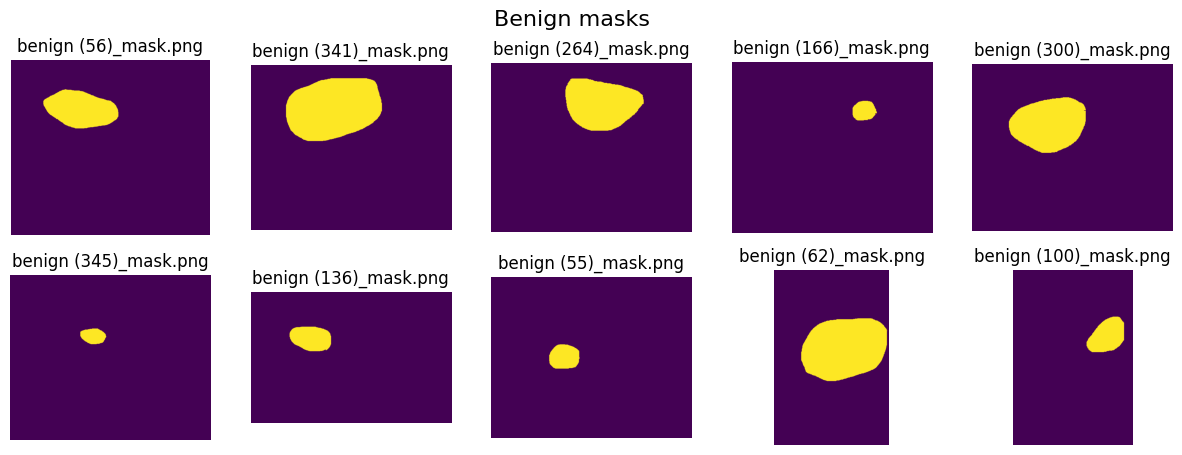

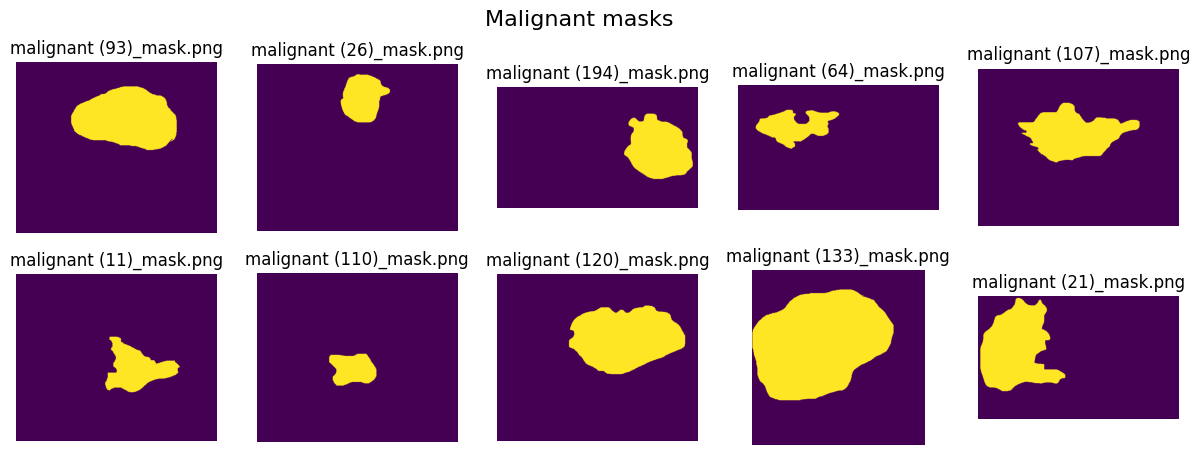

In [10]:
# Benign masks
fig, ax = plt.subplots(2, 5, figsize = (15, 5))
ax = ax.flatten()
plt.suptitle('Benign masks', fontsize = 16)

for i in range(10):
  name = random.choice(listMasB)
  mas = cv2.imread(os.path.join(pathB, name), flags = cv2.IMREAD_UNCHANGED)
  ax[i].imshow(mas)
  ax[i].axis('off')
  ax[i].set_title(name)

# Malignant masks
fig, ax = plt.subplots(2, 5, figsize = (15, 5))
ax = ax.flatten()
plt.suptitle('Malignant masks', fontsize = 16)

for i in range(10):
  name = random.choice(listMasM)
  mas = cv2.imread(os.path.join(pathM, name), flags = cv2.IMREAD_UNCHANGED)
  ax[i].imshow(mas)
  ax[i].axis('off')
  ax[i].set_title(name)

As we see, images seem grayscale with variable shapes, and some masks seem to cover a considerable part of the images, especially in the malignant samples. In addition, some images present annotations such as text or bounding boxes that may affect the segmentation model, although removing them is a difficult task. Let's give a detailed summary of the files in the dataset.

## 2.2. Detailed Data Exploration

In [ ]:
# Create structure of dataframe
strImg = {
  'IMAGE_NAME': [],
  'CLASS': [],
  'HEIGHT': [],
  'WIDTH': [],
  'N_CHANNELS': [],
  'DATA_TYPE': [],
  'N_MASKS': []
}
strMas = {
  'MASK_NAME': [],
  'CLASS': [],
  'HEIGHT': [],
  'WIDTH': [],
  'N_CHANNELS': [],
  'DATA_TYPE': [],
  'SHAPE_MATCH': [],
  'MIN_VALUE': [],
  'MAX_VALUE': [],
  'N_DISTINCT_VALUES': []
}

# Loop over benign and malignant images and masks
for path, listImg, listMas, cls in zip(
    [pathB, pathM],
    [listImgB, listImgM],
    [listMasB, listMasM],
    ['Benign', 'Malignant']
):
  for name in listImg:
    img = cv2.imread(os.path.join(path, name), cv2.IMREAD_UNCHANGED)
    H1, W1, C1 = img.shape
    strImg['IMAGE_NAME'].append(name)
    strImg['CLASS'].append(cls)
    strImg['HEIGHT'].append(H1)
    strImg['WIDTH'].append(W1)
    strImg['N_CHANNELS'].append(C1)
    strImg['DATA_TYPE'].append(img.dtype)

    listMasImg = [x for x in listMas if name[:-4] in x]
    strImg['N_MASKS'].append(len(listMasImg))

    for name in listMasImg:
      mas = cv2.imread(os.path.join(path, name), cv2.IMREAD_UNCHANGED)
      if len(mas.shape) == 2:
        H2, W2 = mas.shape
        C2 = 1
      else:
        H2, W2, C2 = mas.shape
      strMas['MASK_NAME'].append(name)
      strMas['CLASS'].append(cls)
      strMas['HEIGHT'].append(H2)
      strMas['WIDTH'].append(W2)
      strMas['N_CHANNELS'].append(C2)
      strMas['DATA_TYPE'].append(mas.dtype)
      strMas['SHAPE_MATCH'].append(1 if (H1 == H2) and (W1 == W2) else 0)
      strMas['MIN_VALUE'].append(mas.min())
      strMas['MAX_VALUE'].append(mas.max())
      strMas['N_DISTINCT_VALUES'].append(len(np.unique(mas)))

# Create dataframes
dfImg = pd.DataFrame(strImg)
dfMas = pd.DataFrame(strMas)

In [ ]:
print(dfImg['DATA_TYPE'].unique())
print(dfMas['DATA_TYPE'].unique())

[dtype('uint8')]
[dtype('uint8')]


First, we can see that both images and masks are uint8 files.

In [ ]:
print(dfImg[dfImg['CLASS'] == 'Benign'].describe())
print('\n')
print(dfImg[dfImg['CLASS'] == 'Malignant'].describe())

           HEIGHT        WIDTH  N_CHANNELS     N_MASKS
count  437.000000   437.000000       437.0  437.000000
mean   495.471396   613.386728         3.0    1.038902
std     78.141469   117.258102         0.0    0.205088
min    324.000000   315.000000         3.0    1.000000
25%    464.000000   554.000000         3.0    1.000000
50%    471.000000   563.000000         3.0    1.000000
75%    574.000000   706.000000         3.0    1.000000
max    719.000000  1028.000000         3.0    3.000000


           HEIGHT        WIDTH  N_CHANNELS     N_MASKS
count  210.000000   210.000000       210.0  210.000000
mean   494.014286   597.971429         3.0    1.004762
std     60.434668   125.221141         0.0    0.069007
min    332.000000   190.000000         3.0    1.000000
25%    463.000000   552.000000         3.0    1.000000
50%    474.000000   564.000000         3.0    1.000000
75%    554.000000   649.750000         3.0    1.000000
max    677.000000  1048.000000         3.0    2.000000


Regarding the images, the dataset is pretty unbalanced, with the number of benign images (437) doubling the number of malignant images (210). All of the images have 3 channels, with generally one mask per image and a variable shape, averaging 495x613 and 494x598 pixels in benign and malignant samples, respectively.

The low number of masks per image, which is the same as instances per image, suggests that a semantic segmentation approach is appropiate, since the class of each instance is the same within each image. In addition, a reshape to 512x512 pixels seems adequate, and weighting should be applied on the classification methods to account for the unbalanced class distribution.

In [ ]:
print(dfMas[dfMas['CLASS'] == 'Benign'].describe())
print('\n')
print(dfMas[dfMas['CLASS'] == 'Malignant'].describe())

           HEIGHT        WIDTH  N_CHANNELS  SHAPE_MATCH  MIN_VALUE  MAX_VALUE  \
count  454.000000   454.000000  454.000000        454.0      454.0      454.0   
mean   496.229075   614.969163    1.013216          1.0        0.0      255.0   
std     78.017123   117.770117    0.198897          0.0        0.0        0.0   
min    324.000000   315.000000    1.000000          1.0        0.0      255.0   
25%    464.000000   554.000000    1.000000          1.0        0.0      255.0   
50%    471.000000   563.000000    1.000000          1.0        0.0      255.0   
75%    574.000000   726.000000    1.000000          1.0        0.0      255.0   
max    719.000000  1028.000000    4.000000          1.0        0.0      255.0   

       N_DISTINCT_VALUES  
count              454.0  
mean                 2.0  
std                  0.0  
min                  2.0  
25%                  2.0  
50%                  2.0  
75%                  2.0  
max                  2.0  


           HEIGHT        

Regarding the masks, all of them match their image shape, having two unique values: 0 and 255 for background and foreground, respectively. Surprisingly, some masks have more than one channel, let's explore them.


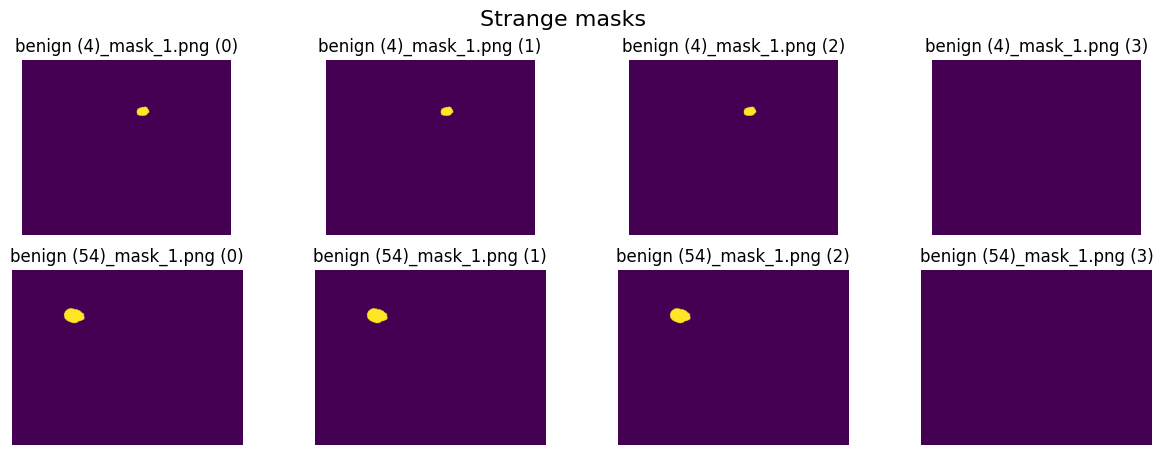

In [ ]:
listStrange = dfMas[dfMas['N_CHANNELS'] > 1]['MASK_NAME']
fig, ax = plt.subplots(len(listStrange), 4, figsize = (15, 5))
plt.suptitle('Strange masks', fontsize = 16)
for i, name in enumerate(listStrange):
  mas = cv2.imread(os.path.join(pathB, name), cv2.IMREAD_UNCHANGED)
  for j in range(4):
    ax[i, j].imshow(mas[:, :, j])
    ax[i, j].axis('off')
    ax[i, j].set_title(f'{name} ({j})')

In [ ]:
for i, name in enumerate(listStrange):
  mas = cv2.imread(os.path.join(pathB, name), cv2.IMREAD_UNCHANGED)
  print(f'-{name}')
  for j in range(1, 4):
    check = 'Yes' if np.prod(mas[:, :, 0] == mas[:, :, j]) == 1 else 'No'
    print(f'\t- Channel 0 equal to channel {j}? {check}')

-benign (4)_mask_1.png
	- Channel 0 equal to channel 1? Yes
	- Channel 0 equal to channel 2? Yes
	- Channel 0 equal to channel 3? No
-benign (54)_mask_1.png
	- Channel 0 equal to channel 1? Yes
	- Channel 0 equal to channel 2? Yes
	- Channel 0 equal to channel 3? No


As we can see, in these cases masks are composed by three equal channels and an empty fourth channel, so we can just keep the first channel.

## 2.3. Data Preprocessing and Dataset Generation

Putting all this exploratory analysis together, we're going to create a dataset to train, validate and test a segmentation model. Image preprocessing will consist in reshaping to 512x512 pixels with linear interpolation, while mask will be reshaped with nearest neighbour interpolation to mantain binary values. For the cases in which more than one instance is present, masks will be combined to create a unique mask. We will split the total dataset into three subsets for training (70%), validation (15%) and testing (15%), mantaining the original unbalanced class distribution. The dataset organization will be as follows:
- DATASET
  - TRAIN
    - IMAGES
    - MASKS
  - VALIDATION
    - IMAGES
    - MASKS
  - TEST
    - IMAGES
    - MASKS

In [ ]:
# Set seed for reproducibility
random.seed(42)

# Loop over benign and malignant images and masks
for path, listImg, listMas in zip(
    [pathB, pathM],
    [listImgB, listImgM],
    [listMasB, listMasM]
):

  # Shuffle the list
  random.shuffle(listImg)
  N = len(listImg)

  # Calculate the sizes of each split
  sizeTrain = int(np.round(0.7 * N, 0))
  sizeVal = int(np.round(0.15 * N, 0))

  for i, name in enumerate(listImg):

    if i < sizeTrain:
      fol = 'TRAIN'
    elif i < sizeTrain + sizeVal:
      fol = 'VALIDATION'
    else:
      fol = 'TEST'

    # Read image
    img = cv2.imread(os.path.join(path, name), flags = cv2.IMREAD_UNCHANGED)

    # Create base mask
    masBase = np.zeros((img.shape[0], img.shape[1]), dtype = 'uint8')

    # Read masks for the selected image and add them
    listMasImg = [x for x in listMas if name[:-4] in x]
    for x in listMasImg:

      # Read mask
      mas = cv2.imread(os.path.join(path, x), flags = cv2.IMREAD_UNCHANGED)

      # Add additional mask to base mask, with the fix for strange masks
      if len(mas.shape) > 2:
        masBase = cv2.bitwise_or(src1 = masBase, src2 = mas[:, :, 0])
      else:
        masBase = cv2.bitwise_or(src1 = masBase, src2 = mas)

    # Get final mask
    mas = masBase

    # Resize image to 512x512 using linear interpolation
    img = cv2.resize(
      src = img,
      dsize = (512, 512),
      interpolation = cv2.INTER_LINEAR
    )

    # Resize mask to 512x512 using nearest neighbor interpolation
    mas = cv2.resize(
      src = mas,
      dsize = (512, 512),
      interpolation = cv2.INTER_NEAREST
    )

    # Save image and mask
    cv2.imwrite(
      os.path.join(pathRoot, 'DATASET', fol, 'IMAGES', name),
      img
    )
    cv2.imwrite(
      os.path.join(pathRoot, 'DATASET', fol, 'MASKS', name),
      mas
    )

**3. Tumour Segmentation**
-

This section focuses on the segmentation of breast cancer tumours using different model architectures, including U-Net, U-Net++, and DeepLabV3. We first employ a custom U-Net implemented in PyTorch and trained from scratch. Subsequently, we evaluate U-Net, U-Net++, and DeepLabV3 models from the `segmentation_models_pytorch` package, pretrained on the ImageNet dataset. These pretrained models are fine-tuned by training their decoders while keeping the encoders frozen.

## 3.1. PyTorch Dataset

In the last section, we preprocessed and structured the data as follows:
- DATASET
  - TRAIN
    - IMAGES
    - MASKS
  - VALIDATION
    - IMAGES
    - MASKS
  - TEST
    - IMAGES
    - MASKS

In order to train and validate a segmentation model, we first need to create a PyTorch dataset to read each image and its mask, allowing for the convenient transformations and augmentations.

In [ ]:
class SegmentationDataset(torch.utils.data.Dataset):
  def __init__(self, fol: str, aug = None, tra = None):
    super().__init__()
    self.imgFol = os.path.join(fol, 'IMAGES')
    self.masFol = os.path.join(fol, 'MASKS')
    self.aug = aug
    self.tra = tra
    self.imgLis = sorted(os.listdir(self.imgFol))

  def __getitem__(self, idx):

    # Read image
    img = cv2.imread(
      os.path.join(self.imgFol, self.imgLis[idx]),
      cv2.IMREAD_COLOR
    )
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32) / 255.0

    # Read mask
    mas = cv2.imread(
      filename = os.path.join(self.masFol, self.imgLis[idx]),
      flags = cv2.IMREAD_GRAYSCALE
    )
    mas = (mas > 0).astype(np.float32)

    # Augmentations
    if self.aug:
      aug = self.aug(image = img, mask = mas)
      img, mas = aug['image'], aug['mask']

    # SMP preprocessing
    if self.tra is not None:
      img = self.tra(img)

    # To tensor
    img = torch.from_numpy(img).permute(2, 0, 1).float()
    mas = torch.from_numpy(mas).unsqueeze(0).float()

    return img, mas

  def __len__(self):
    return len(self.imgLis)

## 3.2. Model Architecture

In this part we implement a custom U-Net architecture. The model is composed of three main components: an encoder, a decoder, and a wrapper module that integrates both parts using skip connections to improve segmentation performance. Pretrained architectures are already defined in the `segmentation_models_pytorch` package, and it's only necessary to import them.

In [ ]:
def convBlock(inChannels: int, outChannels: int, k: int):
  return torch.nn.Sequential(
    torch.nn.Conv2d(
      in_channels = inChannels,
      out_channels = outChannels,
      kernel_size = (k, k),
      stride = 1,
      padding = 'same',
      bias = False
    ),
    torch.nn.BatchNorm2d(outChannels),
    torch.nn.ReLU(inplace = True),
    torch.nn.Conv2d(
      in_channels = outChannels,
      out_channels = outChannels,
      kernel_size = (3, 3),
      stride = 1,
      padding = 'same',
      bias = False
    ),
    torch.nn.BatchNorm2d(outChannels),
    torch.nn.ReLU(inplace = True)
  )

#------------------------------------------------------------------------------#

def up(inChannels: int, outChannels: int, k: int):
  return torch.nn.Sequential(
    torch.nn.ConvTranspose2d(
      in_channels = inChannels,
      out_channels = outChannels,
      kernel_size = (k, k),
      stride = k
    )
  )

#------------------------------------------------------------------------------#

class Encoder(torch.nn.Module):
  def __init__(
    self,
    inChannels: int = 1,
    initChannels: int = 16,
    depthLevels: int = 4,
    dropout: float = 0.2
  ):
    super(Encoder, self).__init__()
    self.depthLevels = depthLevels

    # Initialize dropout
    self.dropout = torch.nn.Dropout(p = dropout)

    # Initialize list of modules
    self.layers = torch.nn.ModuleList()

    # Initialize out channels
    outChannels = initChannels

    # Loop to generate all layers
    for i in range(depthLevels):

      # Convolutional block
      self.layers.append(
        convBlock(
          inChannels = inChannels,
          outChannels = outChannels,
          k = 3
        )
      )

      # Max pooling
      self.layers.append(
        torch.nn.MaxPool2d(kernel_size = (2, 2), stride = 2)
      )

      # Update in and out channels
      inChannels = outChannels
      outChannels = outChannels * 2

    # Bottle neck (last layer of the encoder)
    self.layers.append(
      convBlock(
        inChannels = inChannels,
        outChannels = outChannels,
        k = 3
      )
    )

    # Save feature dimensions
    self.featureDim = outChannels

  def forward(self, x: torch.tensor):
    features = list()

    # Forward loop
    for i in range(self.depthLevels):
      x = self.layers[2 * i](x)
      features.append(x)
      x = self.layers[2 * i + 1](x)
    x = self.dropout(self.layers[-1](x))
    features.append(x)
    return features

#------------------------------------------------------------------------------#

class Decoder(torch.nn.Module):
  def __init__(
    self,
    inChannels: int,
    nClasses: int = 1,
    depthLevels: int = 4,
    skipConnections: bool = True
  ):
    super(Decoder, self).__init__()
    self.depthLevels = depthLevels
    self.skipConnections = skipConnections

    # Initialize list of modules
    self.layers = torch.nn.ModuleList()

    # Initialize out channels
    outChannels = inChannels // 2

    # Loop to generate all layers
    for _ in range(depthLevels):

      # Up block
      self.layers.append(
        up(
          inChannels = inChannels,
          outChannels = outChannels,
          k = 2
        )
      )

      # Convolutional block
      self.layers.append(
        convBlock(
          inChannels = outChannels * 2 if self.skipConnections else outChannels,
          outChannels = outChannels,
          k = 3
        )
      )

      # Update in and out channels
      inChannels = outChannels
      outChannels = inChannels // 2

    # Final (last layer of the decoder)
    self.layers.append(
      torch.nn.Conv2d(
        in_channels = inChannels,
        out_channels = nClasses,
        kernel_size = (3, 3),
        stride = 1,
        padding = 'same',
        bias = False
      )
    )

  def forward(self, features: list):

    # Get bottleneck features
    x = features[-1]

    # Forward loop with or without skip-connections
    for i in range(self.depthLevels):
      x = self.layers[2 * i](x)
      if self.skipConnections:
        x = torch.cat([x, features[-(i + 2)]], dim = 1)
      x = self.layers[2 * i + 1](x)
    return self.layers[-1](x)

#-----------------------------------------------------------------------------#

class UNet(torch.nn.Module):
  def __init__(
    self,
    inChannels: int = 3,
    nClasses: int = 1,
    initChannels: int = 16,
    depthLevels: int = 4,
    dropout: float = 0.2,
    skipConnections: bool = True
  ):
    super(UNet, self).__init__()

    # Encoder
    self.encoder = Encoder(
      inChannels = inChannels,
      initChannels = initChannels,
      depthLevels = depthLevels,
      dropout = dropout
    )

    # Decoder
    self.decoder = Decoder(
      inChannels = self.encoder.featureDim,
      nClasses = nClasses,
      depthLevels = depthLevels,
      skipConnections = skipConnections
    )

  def forward(self, x: torch.tensor):
    features = self.encoder(x)
    return self.decoder(features)


## 3.3. Model training

To train the segmentation models, a suitable loss function must first be defined. A weighted combination of Dice loss and binary cross-entropy loss is defined, with weights of 80% and 20%, respectively.

In [ ]:
def diceBCELoss(preds: torch.Tensor, targs: torch.Tensor):

  # Compute binary cross entropy
  bce = torch.nn.functional.binary_cross_entropy_with_logits(preds, targs.float())

  # Compute probabilities with a sigmoid function
  preds = torch.sigmoid(preds)

  # Compute intersection and union
  dims = (1, 2, 3)
  inter = (preds * targs).sum(dim = dims)
  union = preds.sum(dim = dims) + targs.sum(dim = dims)

  # Compute dice and return 1 - dice
  dice = (2 * inter + 1e-6) / (union + 1e-6)
  dice = dice.mean()

  return 0.8 * (1 - dice) + 0.2 * bce

Finally, a training function is implemented, incorporating early stopping based on the validation loss using a patience criterion. During training, both the last and the best model weights are saved at each iteration, where the best model is defined as the one achieving the lowest validation loss.

In [ ]:
def train(
  model: torch.nn.Module,
  optimizer,
  criterion,
  epochs: int,
  patience: int,
  dlTrain: torch.utils.data.DataLoader,
  dlVal: torch.utils.data.DataLoader,
  dev: torch.DeviceObjType,
  chkFol: str
):

  # Initialize epoch and counter for early stopping
  epoch = 0
  count = 0

  # Initialize best loss
  bestLoss = np.inf

  # Number of steps for the training and validation dataset
  stepsT = len(dlTrain)
  stepsV = len(dlVal)

  # Logs dataframe
  logs = {
    'epoch': list(),
    'time': list(),
    'lossT': list(),
    'lossV': list()
  }

  # Move model to device
  model.to(device = dev)

  # Traing loop
  while (epoch < epochs) and (count < patience):

    # Initialize time
    t0 = time.time()

    # Update logs
    logs['epoch'].append(epoch)
    logs['lossT'].append(0)
    logs['lossV'].append(0)

    # Set model in training mode
    model.train()

    # Set encoder to eval if pretrained
    if 'SMP_' in chkFol:
      model.encoder.eval()

    # Training batch loop
    for batch in dlTrain:

      # Read batch and move to device
      img, mas = batch
      img = img.to(device = dev)
      mas = mas.to(device = dev)

      # Reset gradient
      optimizer.zero_grad()

      # Forward pass
      preds = model(img)

      # Compute loss
      loss = criterion(preds, mas)

      # Backward pass
      loss.backward()
      optimizer.step()

      # Update logs
      logs['lossT'][-1] += loss.item()

    # Set model in evaluation mode
    model.eval()

    # Disable gradient calculations
    with torch.no_grad():

      # Validation batch loop
      for batch in dlVal:

        # Read batch and move to device
        img, mas = batch
        img = img.to(device = dev)
        mas = mas.to(device = dev)

        # Forward pass
        preds = model(img)

        # Compute loss
        loss = criterion(preds, mas)

        # Update logs
        logs['lossV'][-1] += loss.item()

      # Update logs based on the number of steps
      logs['lossT'][-1] /= stepsT
      logs['lossV'][-1] /= stepsV

    # Calculate time
    t1 = time.time()
    t = (t1 - t0) / 60.0
    logs['time'].append(t)

    # Print progress
    print((
      f'Epoch [{epoch} / {epochs}] | '
      f'Time: {logs['time'][-1]: .2f} | '
      f'T. Loss: {logs['lossT'][-1]: .2f} | '
      f'V. Loss: {logs['lossV'][-1]: .2f} | '
    ))

    # Initialize binary saving variable
    saveLoss = False

    # Check if loss has improved and update counter for early stopping
    if (logs['lossV'][-1] < bestLoss):
        saveLoss = True
        bestLoss = logs['lossV'][-1]
        count = 0
    else:
        count += 1

    # Save last and best model weights
    torch.save(model.state_dict(), f'{chkFol}/last.pth')
    if saveLoss:
        torch.save(model.state_dict(), f'{chkFol}/bestLoss.pth')

    epoch += 1

  # Save logs to excel file
  logs = pd.DataFrame(logs)
  logs.to_excel(f'{chkFol}/logs.xlsx', index = False)

In the subsequent part, the models are trained for up to 100 epochs, employing an early-stopping patience of 10 epochs.

In [ ]:
# Check device
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {dev}')

# Model initializations
unetCus = UNet(
  inChannels = 3,
  nClasses = 1,
  initChannels = 16,
  dropout = 0.2,
  depthLevels = 4
)
unetSMP = smp.Unet(
  encoder_name = 'resnet34',
  encoder_weights = 'imagenet',
  in_channels = 3,
  classes = 1
)
unetPPSMP = smp.UnetPlusPlus(
  encoder_name = 'resnet34',
  encoder_weights = 'imagenet',
  in_channels = 3,
  classes = 1
)
deepLabV3SMP = smp.DeepLabV3(
  encoder_name = 'resnet34',
  encoder_weights = 'imagenet',
  in_channels = 3,
  classes = 1
)

# Augmentations
aug = A.Compose([
  A.HorizontalFlip(p = 0.5),
  A.VerticalFlip(p = 0.5),
  A.ColorJitter(
      brightness = 0.2,
      contrast = 0.2,
      saturation = 0.2,
      hue = 0.1,
      p = 0.5
  ),
])

# SMP preprocessing
traSMP = smp.encoders.get_preprocessing_fn(
  encoder_name = 'resnet34',
  pretrained = 'imagenet'
)

# Datasets
dsTrainCus = SegmentationDataset(
  fol = os.path.join(pathRoot, 'DATASET', 'TRAIN'),
  aug = aug,
  tra = None
)
dsValCus = SegmentationDataset(
  fol = os.path.join(pathRoot, 'DATASET', 'VALIDATION'),
  aug = None,
  tra = None
)
dsTrainSMP = SegmentationDataset(
  fol = os.path.join(pathRoot, 'DATASET', 'TRAIN'),
  aug = aug,
  tra = traSMP
)
dsValSMP = SegmentationDataset(
  fol = os.path.join(pathRoot, 'DATASET', 'VALIDATION'),
  aug = None,
  tra = traSMP
)

# Dataloaders
dlTrainCus = torch.utils.data.DataLoader(
  dataset = dsTrainCus,
  batch_size = 16,
  shuffle = True
)
dlValCus = torch.utils.data.DataLoader(
  dataset = dsValCus,
  batch_size = 16,
  shuffle = False
)
dlTrainSMP = torch.utils.data.DataLoader(
  dataset = dsTrainSMP,
  batch_size = 16,
  shuffle = True
)
dlValSMP = torch.utils.data.DataLoader(
  dataset = dsValSMP,
  batch_size = 16,
  shuffle = False
)

# Pack in list
models = [
  (unetCus, 'CUS_UNET', dlTrainCus, dlValCus),
  (unetSMP, 'SMP_UNET', dlTrainSMP, dlValSMP),
  (unetPPSMP, 'SMP_UNETPP', dlTrainSMP, dlValSMP),
  (deepLabV3SMP, 'SMP_DEEPLABV3', dlTrainSMP, dlValSMP)
]

# for (model, name, dlTrain, dlVal) in models:

#   # Define criterion and optimizer
#   criterion = diceBCELoss

#   # Freeze encoder if pretrained
#   if 'SMP_' in name:
#     for p in model.encoder.parameters():
#       p.requires_grad = False

#   # Initialize optimizer
#   optimizer = torch.optim.AdamW(
#     params = [p for p in model.parameters() if p.requires_grad],
#     lr = 1e-3,
#     weight_decay = 1e-4
#   )

#   # Train
#   train(
#     model = model,
#     optimizer = optimizer,
#     criterion = criterion,
#     epochs = 100,
#     patience = 10,
#     dlTeain = dlTrain,
#     dlVal = dlVal,
#     dev = dev,
#     chkFol = os.path.join(pathRoot, 'CHECKPOINTS', 'SEGMENTATION', name)
#   )

Device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

Let's visualize the training curves.

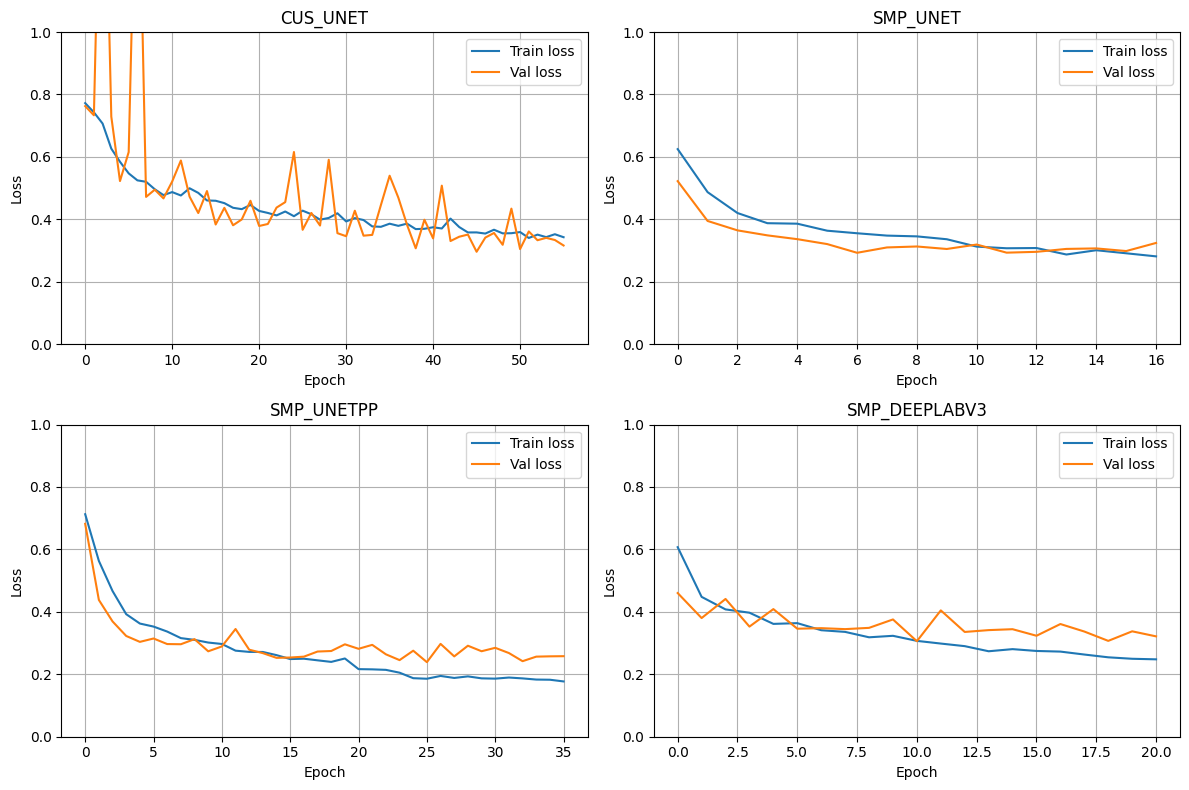

In [ ]:
# Pack in list
models = [
  ('CUS_UNET', (0, 0)),
  ('SMP_UNET', (0, 1)),
  ('SMP_UNETPP', (1, 0)),
  ('SMP_DEEPLABV3', (1, 1))
]

# Initialize figure
fig, ax = plt.subplots(2, 2, figsize = (12, 8))

# Loop over model results
for name, (i, j) in models:

  # Get logs for each model
  logs = pd.read_excel(os.path.join(
    pathRoot,
    'CHECKPOINTS',
    'SEGMENTATION',
    name,
    'logs.xlsx'
  ))

  # Plot training and validation curves
  ax[i, j].plot(logs['epoch'], logs['lossT'], label = 'Train loss')
  ax[i, j].plot(logs['epoch'], logs['lossV'], label = 'Val loss')

  # Add title, labels and legend
  ax[i, j].set_title(name)
  ax[i, j].set_xlabel('Epoch')
  ax[i, j].set_ylabel('Loss')
  ax[i, j].set_ylim(0, 1)
  ax[i, j].grid(True)
  ax[i, j].legend()

plt.tight_layout()

# Show figure
plt.show()

## 3.4. Model comparison

In this last part, we compare the performance of the different models on the validation dataset.

In [ ]:
def multiMetrics(confmat: torch.tensor):

  # Basic metrics
  TP = torch.diag(confmat)
  FP = confmat.sum(dim = 0) - TP
  FN = confmat.sum(dim = 1) - TP

  # Per-class metrics
  iou = TP / (TP + FP + FN + 1e-8)
  dice = 2 * TP / (2 * TP + FP + FN + 1e-8)
  precision = TP / (TP + FP + 1e-8)
  recall = TP / (TP + FN + 1e-8)
  accuracy = TP.sum() / confmat.sum()

  return iou, dice, precision, recall, accuracy

In [ ]:
# Initialize confusion matrix
cm = torchmetrics.classification.BinaryConfusionMatrix(threshold = 0.5)
cm = cm.to(device = dev)

# Initialize structure for the dataset
str = {
  'MODEL': [],
  'IOU': [],
  'DICE': [],
  'PRECISION': [],
  'RECALL': [],
  'ACCURACY': [],
}

# Pack in list
models = [
  (unetCus, 'CUS_UNET', dlValCus),
  (unetSMP, 'SMP_UNET', dlValSMP),
  (unetPPSMP, 'SMP_UNETPP', dlValSMP),
  (deepLabV3SMP, 'SMP_DEEPLABV3', dlValSMP)
]

for (model, name, dlVal) in models:

  # Load best weights and move to device
  model.load_state_dict(torch.load(
      os.path.join(
        pathRoot,
        'CHECKPOINTS',
        'SEGMENTATION',
        name,
        'bestLoss.pth'
      ),
      weights_only = True
  ))
  model = model.to(device = dev)

  # Reset confusion matrix
  cm.reset()

  # Set model in evaluation mode
  model.eval()

  # Disable gradient calculations
  with torch.no_grad():

    # Validation batch loop
    for batch in dlVal:

      # Read batch and move to device
      img, mas = batch
      img = img.to(device = dev)
      mas = mas.to(device = dev)

      # Forward pass with sigmoid function
      preds = torch.sigmoid(model(img))

      # Update confusion matrix
      cm.update(preds, mas)

  confmat = cm.compute()
  iou, dice, pre, rec, acc = multiMetrics(confmat)

  str['MODEL'].append(name)
  str['IOU'].append(iou[1].item())
  str['DICE'].append(dice[1].item())
  str['PRECISION'].append(pre[1].item())
  str['RECALL'].append(rec[1].item())
  str['ACCURACY'].append(acc.item())

metrics = pd.DataFrame(str)
metrics.to_excel(os.path.join(
    pathRoot,
    'RESULTS',
    'metrics.xlsx'
  ),
  index = False
)

# Visualize metrics
print(metrics)

           MODEL       IOU      DICE  PRECISION    RECALL  ACCURACY
0       CUS_UNET  0.530610  0.693331   0.770737  0.630054  0.948417
1       SMP_UNET  0.555339  0.714107   0.783618  0.655923  0.951394
2     SMP_UNETPP  0.609456  0.757344   0.854124  0.680264  0.959657
3  SMP_DEEPLABV3  0.554860  0.713711   0.682400  0.748033  0.944461


As we can see, the pretrained UNet++ achieves the best metrics overall, even though the pretrained DeepLabV3 presents a higher recall. Finally, let's visualize the predictions on the first validation batch for each model.

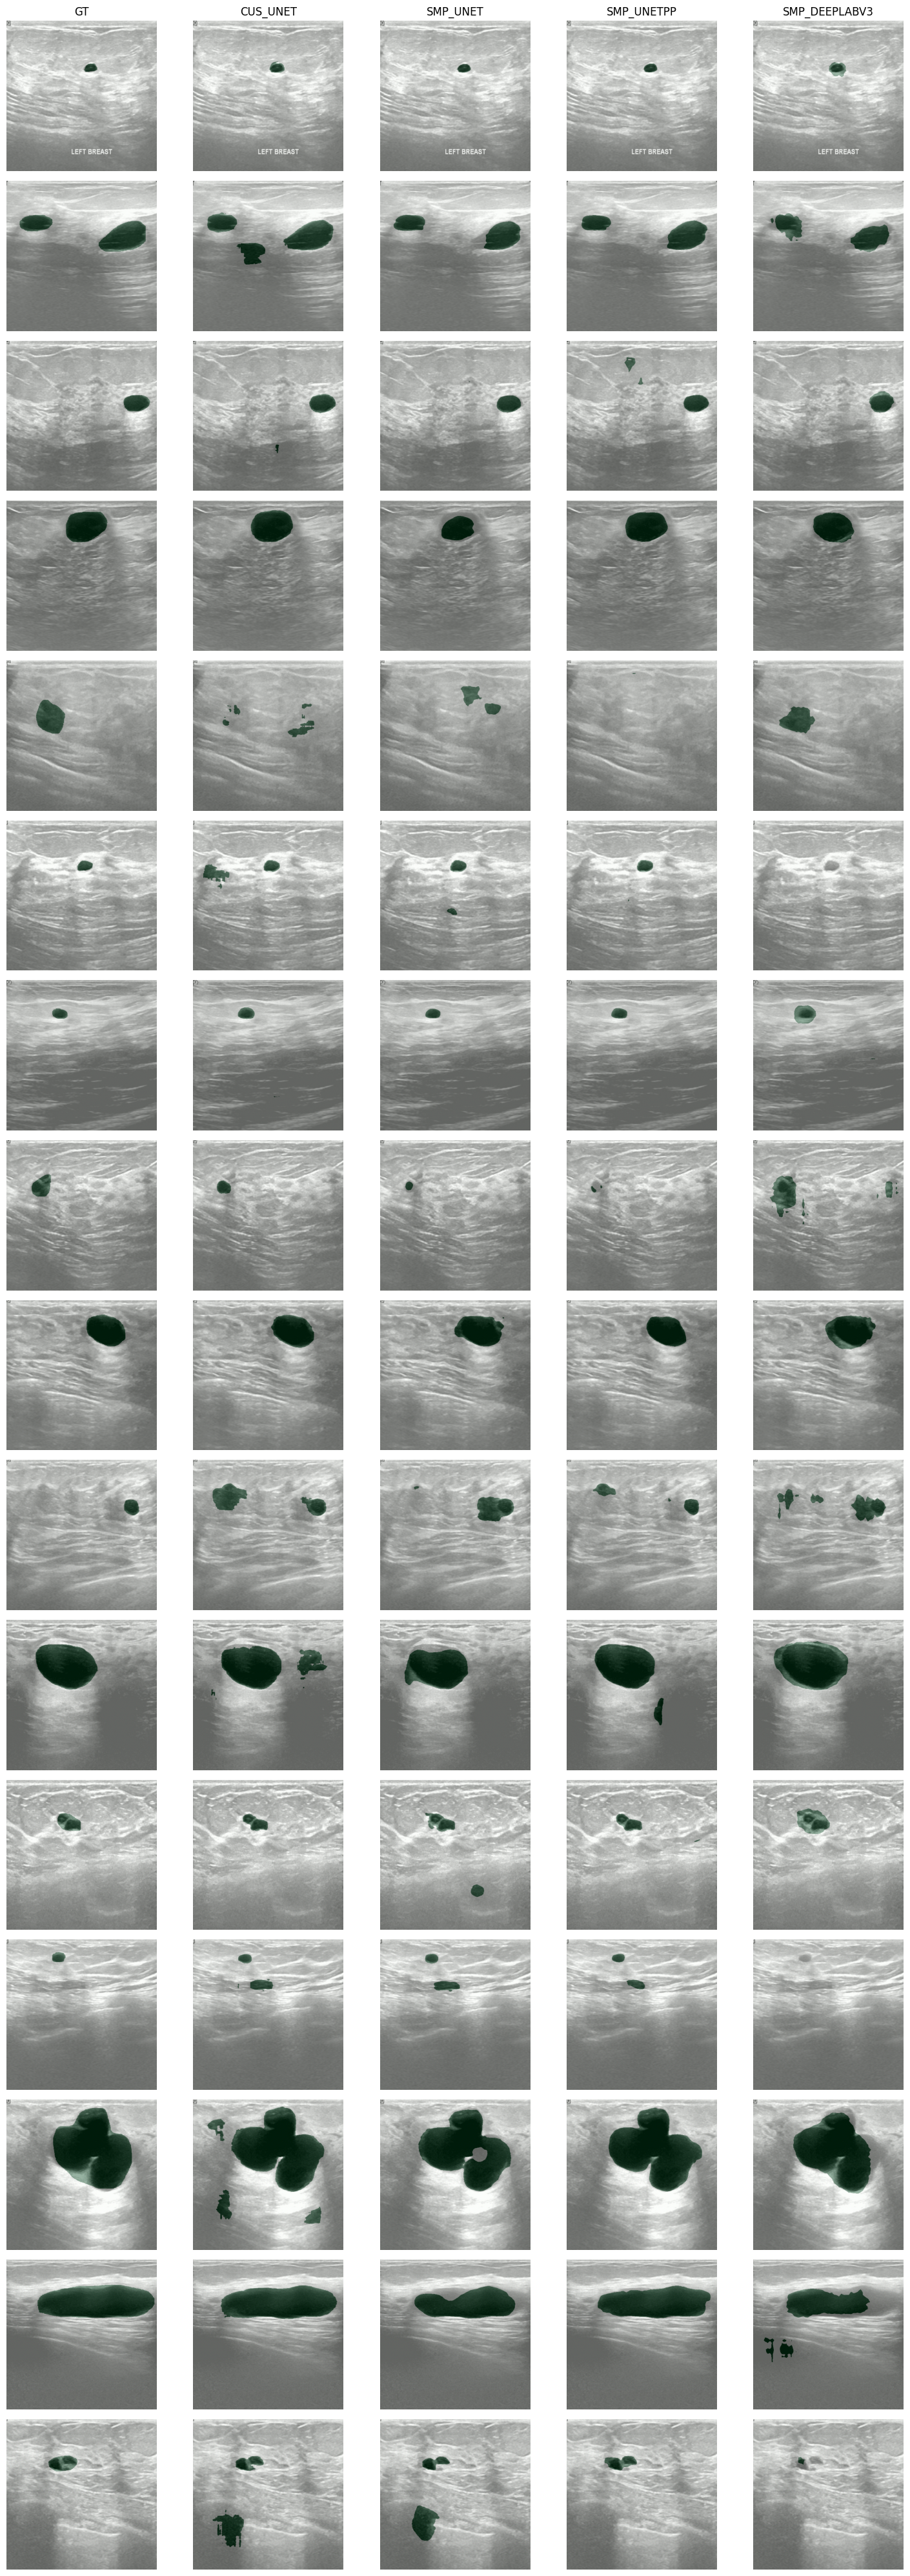

In [ ]:
# Pack in list
models = [
  (None, 'GT', dlValCus),
  (unetCus, 'CUS_UNET', dlValCus),
  (unetSMP, 'SMP_UNET', dlValSMP),
  (unetPPSMP, 'SMP_UNETPP', dlValSMP),
  (deepLabV3SMP, 'SMP_DEEPLABV3', dlValSMP)
]

# Initialize figure
fig, axes = plt.subplots(16, 5, figsize=(15, 40))

# Get raw image to plot
imgPlot, _ = next(iter(dlValCus))

# Loop over models and plot predictions
for j, (model, name, dlVal) in enumerate(models):

  # Get preprocessed image and move to device
  img, mas = next(iter(dlVal))
  img = img.to(dev)

  # If GT then preds is just the mask
  if name == 'GT':
    pred = mas

  # If not GT get predictions
  else:

    # Load best weights and move to device
    model.load_state_dict(torch.load(
      os.path.join(
        pathRoot,
        'CHECKPOINTS',
        'SEGMENTATION',
        name,
        'bestLoss.pth'
      ),
      weights_only = True
  ))
    model = model.to(device = dev)

    # Get predictions
    with torch.no_grad():
      pred = torch.sigmoid(model(img))

  # Squeeze predictions, move back to cpu and threshold
  pred = pred.squeeze(1).cpu().numpy() > 0.5

  # Loop over images within the batch and plot them
  for i in range(16):

    # Get axis
    ax = axes[i, j]
    ax.axis('off')

    # Plot image and overlay prediction
    ax.imshow(imgPlot[i].permute(1, 2, 0).numpy())
    ax.imshow(pred[i], cmap = 'Greens', alpha = 0.4)

    # Plot title
    if i == 0:
      ax.set_title(name, fontsize = 12)

plt.tight_layout()

# Save figure
plt.savefig(
  os.path.join(pathRoot, 'RESULTS', 'segmentationComparison.png'),
  dpi = 300,
  bbox_inches = 'tight'
)

# Show figure
plt.show()